In [1]:
import pandas as pd

df = pd.read_parquet(r"C:\\Users\\luisc\\local\\projetos\\videos\\rnn_corrector\\data\\wikipedia_2025.pq")
df.head()

,id,revid:,title,url,text
0,5674408,662262,Anna Chandy,https://pt.wikipedia.org/wiki?curid=5674408,"Anna Chandy (1905-1996), também conhecida como..."
1,5674410,321756,Ajahn Mahā Bua,https://pt.wikipedia.org/wiki?curid=5674410,"Ajahn Mahā Bua (Udon Thani, 12 de agosto de 19..."
2,5674413,2702392,Debra Elmegreen,https://pt.wikipedia.org/wiki?curid=5674413,"Debra Meloy Elmegreen (South Bend, Indiana, 23..."
3,5674416,2123556,Laura Ferrarese,https://pt.wikipedia.org/wiki?curid=5674416,Laura Ferrarese é uma pesquisadora em ciência ...
4,5674418,710641,Anna Chandi,https://pt.wikipedia.org/wiki?curid=5674418,


In [2]:
df = df[df.text.str.len() > 0].reset_index(drop=True)
df.head()

,id,revid:,title,url,text
0,5674408,662262,Anna Chandy,https://pt.wikipedia.org/wiki?curid=5674408,"Anna Chandy (1905-1996), também conhecida como..."
1,5674410,321756,Ajahn Mahā Bua,https://pt.wikipedia.org/wiki?curid=5674410,"Ajahn Mahā Bua (Udon Thani, 12 de agosto de 19..."
2,5674413,2702392,Debra Elmegreen,https://pt.wikipedia.org/wiki?curid=5674413,"Debra Meloy Elmegreen (South Bend, Indiana, 23..."
3,5674416,2123556,Laura Ferrarese,https://pt.wikipedia.org/wiki?curid=5674416,Laura Ferrarese é uma pesquisadora em ciência ...
4,5674419,445460,Dorrit Hoffleit,https://pt.wikipedia.org/wiki?curid=5674419,Ellen Dorrit Hoffleit (12 de março de 1907 – 9...


In [3]:
df = df.sample(frac=1).reset_index(drop=True)

treino = df.iloc[:10_000]

teste = df.iloc[11_000:12_000].reset_index(drop=True)

In [4]:
from tokenizer import BPETokenizer

tokenizer = BPETokenizer()
tokenizer.train(treino.text.tolist(), vocab_size=100_000)

  0%|          | 5/99744 [00:26<147:57:07,  5.34s/it]


KeyboardInterrupt: 

In [5]:
from tokenizer_v2 import BPETokenizer

tokenizer = BPETokenizer()
tokenizer.train(treino.text.tolist(), vocab_size=100_000)

Pré-processando textos...


  0%|          | 237/99744 [01:07<7:54:45,  3.49it/s]


KeyboardInterrupt: 

In [6]:
from tokenizer_v3 import BPETokenizer

tokenizer = BPETokenizer()
tokenizer.train(treino.text.tolist(), vocab_size=100_000)

Pré-processando textos...


Treinando BPE: 100%|██████████| 99744/99744 [05:25<00:00, 306.07merge/s, max_freq=32, vocab=1e+5]  


In [7]:
tokenizer.print_merges()

(111, 32) -> o 
(100, 101) -> de
(114, 97) -> ra
(110, 116) -> nt
(105, 115) -> is
(195, 163) -> ã
(113, 117) -> qu
(109, 112) -> mp
(108, 104) -> lh
(226, 128) -> �
(169, 99) -> �c
(194, 160) ->  
(173, 118) -> �v
(73, 73) -> II
(186, 98) -> �b
(161, 103) -> �g
(69, 120) -> Ex
(102, 102) -> ff
(84, 86) -> TV
(85, 83) -> US
(80, 67) -> PC
(122, 122) -> zz
(107, 121) -> ky
(78, 65) -> NA
(88, 88) -> XX
(196, 135) -> ć
(87, 87) -> WW
(77, 68) -> MD
(208, 176) -> а
(197, 141) -> ō
(66, 82) -> BR
(209, 129) -> с
(79, 76) -> OL
(75, 70) -> KF
(227, 131) -> �
(206, 177) -> α
(179, 119) -> �w
(134, 146) -> ��
(207, 137) -> ω
(224, 164) -> �
(216, 167) -> ا
(203, 144) -> ː
(225, 184) -> �
(130, 172) -> ��
(71, 72) -> GH
(217, 132) -> ل
(200, 153) -> ș
(74, 74) -> JJ
(202, 191) -> ʿ
(213, 182) -> ն
(201, 170) -> ɪ
(215, 149) -> ו
(214, 188) -> ּ
(136, 165) -> ��
(236, 157) -> �
(229, 143) -> �
(230, 156) -> �
(106, 106) -> jj
(90, 90) -> ZZ
(231, 148) -> �
(235, 133) -> �
(233, 150) -> �
(232, 

In [8]:
tokenizer.save("bpe_tokenizer_100k.json")

In [9]:
from tqdm import tqdm

def get_dataset_tokenized_len_parallel(texts, tokenizer):
    token_lens = 0
    resultado = tokenizer.batch_encode(texts, num_workers=10)
    for r in resultado:
        token_lens += len(r)
    return token_lens

tamanhos = [100_000, 90_000, 80_000, 70_000, 60_000, 50_000, 40_000, 30_000, 20_000, 10_000, 5_000, 2_000, 1_000]
dados = {
    "vocab_size": [],
    "num_tokens": [],
}

for tamanho in tamanhos:
    quantidade_merges = tamanho - 256
    chaves = tokenizer.merges.keys()
    for k in list(chaves)[quantidade_merges:]:
        tokenizer.merges.pop(k)
    num_tokens = get_dataset_tokenized_len_parallel(teste.text.values, tokenizer)
    dados["vocab_size"].append(tamanho)
    dados["num_tokens"].append(num_tokens)

Tokenizando em paralelo: 100%|██████████| 1000/1000 [00:05<00:00, 175.91doc/s]


In [10]:
dados = pd.DataFrame(dados)
dados

,vocab_size,num_tokens
0,100000,481297
1,90000,484003
2,80000,487129
3,70000,491154
4,60000,496356
5,50000,503148
6,40000,512726
7,30000,527211
8,20000,552652
9,10000,613542


In [11]:
tamanho_orig = 0
for t in teste.text.values:
    tamanho_orig += len(t)
tamanho_orig

1912605

In [12]:
dados = dados.sort_values("vocab_size", ascending=True).reset_index(drop=True)

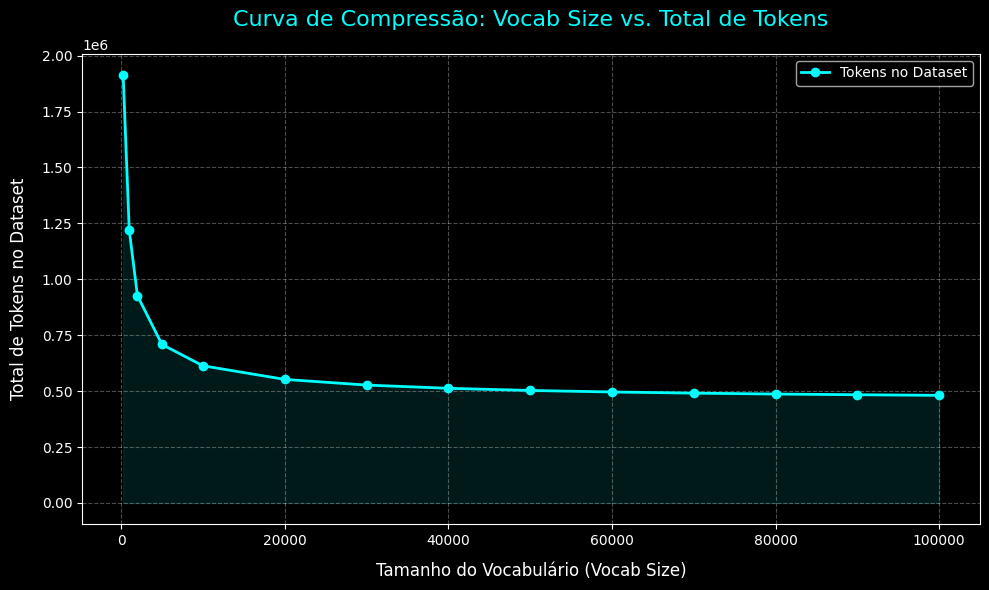

In [13]:
import matplotlib.pyplot as plt

# Substitua estes valores pelos dados que você coletou nos seus testes
vocab_sizes = [256] + dados.vocab_size.tolist()
total_tokens = [1912605] + dados.num_tokens.tolist()

# Configuração de estilo "Dark Tech" para o vídeo
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 6))

# Plotagem da curva (Ciano Neon)
ax.plot(vocab_sizes, total_tokens, marker='o', linestyle='-', 
        color='#00FFFF', linewidth=2, markersize=6, label='Tokens no Dataset')

# Efeito de preenchimento sutil (Glow)
ax.fill_between(vocab_sizes, total_tokens, color='#00FFFF', alpha=0.1)

# Títulos e Rótulos (Ajuste as fontes para ficarem legíveis no vídeo)
ax.set_title('Curva de Compressão: Vocab Size vs. Total de Tokens', fontsize=16, pad=20, color='#00FFFF')
ax.set_xlabel('Tamanho do Vocabulário (Vocab Size)', fontsize=12, labelpad=10)
ax.set_ylabel('Total de Tokens no Dataset', fontsize=12, labelpad=10)

# Grid sutil para referência técnica
ax.grid(True, linestyle='--', alpha=0.3)

# Legenda
ax.legend()

# Ajuste fino para não cortar rótulos
plt.tight_layout()

# Salvar para inserir na edição
plt.savefig('curva_compressao_bpe.png', dpi=300)

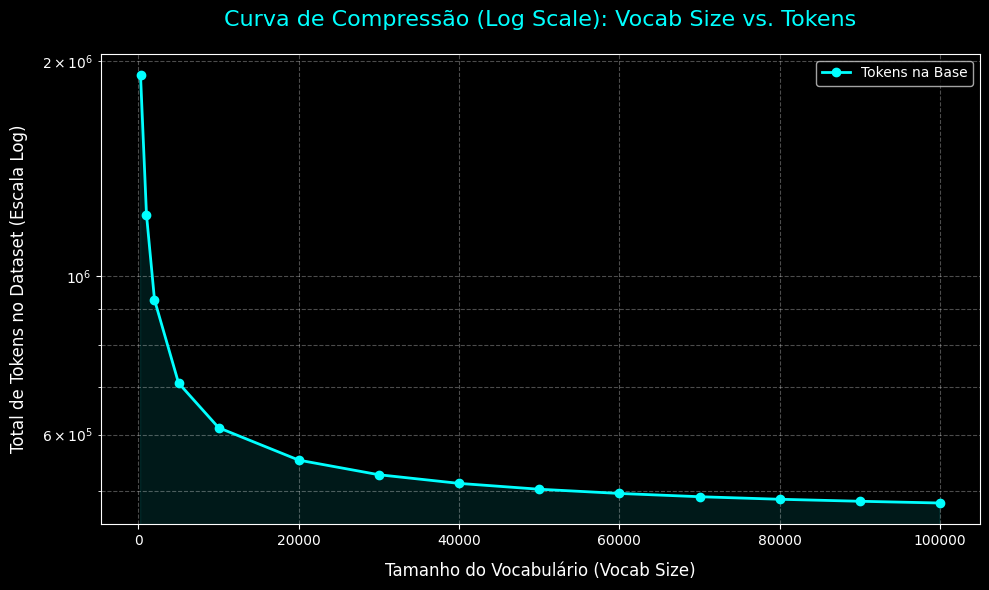

In [14]:
# Substitua estes valores pelos dados que você coletou nos seus testes
vocab_sizes = [256] + dados.vocab_size.tolist()
total_tokens = [1912605] + dados.num_tokens.tolist()

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(vocab_sizes, total_tokens, marker='o', linestyle='-', 
        color='#00FFFF', linewidth=2, markersize=6, label='Tokens na Base')

ax.fill_between(vocab_sizes, total_tokens, color='#00FFFF', alpha=0.1)

# A MÁGICA: Escala Logarítmica no Eixo Y
ax.set_yscale('log')

# Títulos e Rótulos
ax.set_title('Curva de Compressão (Log Scale): Vocab Size vs. Tokens', fontsize=16, pad=20, color='#00FFFF')
ax.set_xlabel('Tamanho do Vocabulário (Vocab Size)', fontsize=12, labelpad=10)
ax.set_ylabel('Total de Tokens no Dataset (Escala Log)', fontsize=12, labelpad=10)

# Grid ajustado para mostrar as linhas da escala logarítmica
ax.grid(True, which="both", linestyle='--', alpha=0.3)

ax.legend()
plt.tight_layout()
plt.savefig('curva_compressao_log.png', dpi=300)